## Analysis

We have decided to analyze US Traffic Accidents between 2016-2023, although 2023 has not completed yet. 
After reviewing the data, we see that over the past 7 years there has been a substantial increase in traffic accidents for the United States. 
Furthermore, cities with a population over 100K have contributed to over 55% of all Traffic Accidents between 2016 and 2022. 
In the US over 60% of Accidents happened during the day for 2016-2022. 
Looking at the most recent completed year (2022) more accidents happen between the hours of 1pm – 6pm. 

In [1]:
#Imports
import pandas as pd
import csv
from api_keys import census_api
import json
import requests
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import numpy as np

In [2]:
#Input
traffic_data = "./Resources/US_Accidents_March23.csv"

In [3]:
traffic_df=pd.read_csv(traffic_data)
traffic_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
#Creating DataFrame w/ reduced columns
reduced_traffic_df = traffic_df[["Start_Time","End_Time","Severity","City","State","Weather_Condition",
                                 "Temperature(F)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)",\
                                 "Sunrise_Sunset","Description","Bump","Crossing", "Give_Way","Junction",\
                                 "No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming",\
                                 "Traffic_Signal","Turning_Loop","Description"
                                ]]
reduced_traffic_df.shape

(7728394, 25)

In [5]:
#Using function to parse date and convert to string
def parse_time(raw):
    date = dt.datetime.fromisoformat(raw).date()
    string = date.isoformat()
    return string

In [6]:
reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time).copy()
reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time).copy()

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/282751100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time).copy()
/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/282751100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time).copy()


In [7]:
#using function to extract Year from date
def year(raw):
    year_string = raw[:4]
    year_integer = int(year_string)
    return year_integer  

In [8]:
reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year).copy()
reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year).copy()

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/3037629889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year).copy()
/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/3037629889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year).copy()


In [9]:
#dropping NA from df
drop_traffic_df = reduced_traffic_df.dropna(how='any')
drop_traffic_df.shape

(5382749, 29)

In [10]:
#Using function to format the drop traffic dataframe
drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
drop_traffic_df.loc[:, "Start_Year"] = drop_traffic_df['Start_Date'].map(year)
drop_traffic_df.loc[:, "End_Year"] = drop_traffic_df['End_Date'].map(year)
drop_traffic_df.shape

(5382749, 29)

In [11]:
#reorganizing columns
organized_traffic_df = reduced_traffic_df[["Start_Year","Start_Date","End_Year","End_Date","Start_Time","End_Time",\
                                        "Severity","City","State","Weather_Condition","Temperature(F)","Visibility(mi)",\
                                        "Wind_Speed(mph)","Precipitation(in)","Sunrise_Sunset","Description","Bump",\
                                        "Crossing", "Give_Way","Junction","No_Exit","Railway","Roundabout","Station",\
                                        "Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]]
organized_traffic_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,2016-02-08,2016,2016-02-08,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
1,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
2,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,...,False,False,False,False,False,False,False,False,True,False
3,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
4,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,True,False


In [12]:
organized_traffic_gp = organized_traffic_df.groupby(["Start_Year"]).State.count()
organized_traffic_gp

Start_Year
2016     410821
2017     718093
2018     893426
2019     954303
2020    1178913
2021    1563753
2022    1762452
2023     246633
Name: State, dtype: int64

In [13]:
#Calling Census API
base_url = "https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*"
api_url = f"{base_url}&key={census_api}"

#Creating DataFrame from API
api_df = pd.read_json(api_url)

df = api_df[1:-1]
df.columns=["City","Population","State #","Place #"]
df.head()

,City,Population,State #,Place #
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
5,"Akron town, Alabama",385,01,00676


In [16]:
#Splitting City and State
split_cl = df["City"].str.split(',',expand=True)

In [17]:
#Renaming Column Header
split_cl.columns=["City_1","State",""]
split_cl

,City_1,State,
1,Abanda CDP,Alabama,None
2,Abbeville city,Alabama,None
3,Adamsville city,Alabama,None
4,Addison town,Alabama,None
5,Akron town,Alabama,None
...,...,...,...
31903,Villa Sin Miedo comunidad,Puerto Rico,None
31904,Voladoras comunidad,Puerto Rico,None
31905,Yabucoa zona urbana,Puerto Rico,None
31906,Yauco zona urbana,Puerto Rico,None


In [18]:
new_df =pd.concat([df,split_cl],axis=1)
drop_df = new_df.drop([""],axis=1)
drop_df.head()

,City,Population,State #,Place #,City_1,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [19]:
#creating function to trim spaces
def trim(raw):
    trim = raw.strip()
    return trim

In [20]:
#Trimming space on State Column
drop_df["State"]= drop_df["State"].map(trim)

In [21]:
#renaming columns
census_rename_df = drop_df.rename(columns={"City":"City_State","City_1":"City"})
census_rename_df.head()

,City_State,Population,State #,Place #,City,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [22]:
#reordering columns
organized_census_df = census_rename_df[["City","State","Population","State #","Place #","City_State" 
]]
organized_census_df.head()

,City,State,Population,State #,Place #,City_State
1,Abanda CDP,Alabama,231,01,00100,"Abanda CDP, Alabama"
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
4,Addison town,Alabama,697,01,00484,"Addison town, Alabama"
5,Akron town,Alabama,385,01,00676,"Akron town, Alabama"


In [23]:
#Pulling City and excluding Puerto Rico
census_clean_df = organized_census_df[(organized_census_df["City"].str.contains("city")) \
                                      & (organized_census_df["State"] != "Puerto Rico")]
census_clean_df

,City,State,Population,State #,Place #,City_State
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama"
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama"
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama"
...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming"
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming"
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming"
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming"


In [24]:
#converting population to integer
census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)

In [25]:
#Function to strip "city" from City
def strip(raw):
    city = raw.strip("city")
    trim = city.strip()
    return trim

In [26]:
census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip).copy()

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/2339864775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip).copy()


In [27]:
city_rename = census_clean_df.rename(columns={"City": "City1","City2": "City"})
city_rename

,City1,State,Population,State #,Place #,City_State,City
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City
...,...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming",Riverton
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming",Rock Springs
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming",Sheridan
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming",Torrington


In [28]:
#importing City and State abbrev.
crosswalk_path = "Resources/crosswalk.csv"
state_abv = pd.read_csv(crosswalk_path)

In [29]:
#merging abbriviation data to census
crosswalk_state = pd.merge(city_rename,state_abv,on="State")

In [30]:
rename_cross = crosswalk_state.rename(columns={"State":"State_old","Abbreviation":"State"})
rename_cross.head()

,City1,State_old,Population,State #,Place #,City_State,City,State
0,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville,AL
1,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville,AL
2,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster,AL
3,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville,AL
4,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City,AL


In [31]:
sorted_og_traffic = organized_traffic_df.sort_values(by=["State","City"],ascending=True)
sorted_og_traffic.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
523666,2022,2022-08-27,2022,2022-08-27,2022-08-27 14:47:41,2022-08-27 15:17:20,2,Abbeville,AL,Thunder in the Vicinity,...,True,False,False,False,False,False,False,False,False,False
530035,2022,2022-08-20,2022,2022-08-20,2022-08-20 16:32:02,2022-08-20 17:01:44,2,Abbeville,AL,Fair,...,False,False,False,False,False,False,False,False,False,False
536021,2022,2022-08-12,2022,2022-08-12,2022-08-12 20:30:17,2022-08-12 21:19:12,1,Abbeville,AL,Fair,...,True,False,False,False,False,False,False,False,False,False
548951,2022,2022-07-29,2022,2022-07-29,2022-07-29 06:38:49,2022-07-29 07:38:24,2,Abbeville,AL,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
557220,2022,2022-07-20,2022,2022-07-20,2022-07-20 12:57:22,2022-07-20 13:40:00,2,Abbeville,AL,Partly Cloudy,...,False,False,False,False,False,False,False,False,False,False


In [32]:
state_accidents = sorted_og_traffic.groupby(["Start_Year","State","City"]).count()

In [33]:
#resetting index on state_accidents
clean_reset_df = state_accidents.reset_index()
clean_reset_df

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2016,AL,Athens,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2016,AL,Atmore,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,2016,AL,Attalla,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,2016,AL,Auburn,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97722,2023,WY,Rock Springs,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
97723,2023,WY,Sinclair,36,36,36,36,36,36,33,...,36,36,36,36,36,36,36,36,36,36
97724,2023,WY,Wamsutter,77,77,77,77,77,77,29,...,77,77,77,77,77,77,77,77,77,77
97725,2023,WY,Wheatland,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [34]:
#merging Census and City Traffic data
state_city_accident_census = pd.merge(clean_reset_df,rename_cross,on=["State","City"],how="inner")
state_city_accident_census

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,City1,State_old,Population,State #,Place #,City_State
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
1,2018,AL,Ashville,11,11,11,11,11,11,11,...,11,11,11,11,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
2,2019,AL,Ashville,8,8,8,8,8,8,8,...,8,8,8,8,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
3,2020,AL,Ashville,7,7,7,7,7,7,7,...,7,7,7,7,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
4,2021,AL,Ashville,18,18,18,18,18,18,15,...,18,18,18,18,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,2023,TX,Talco,1,1,1,1,1,1,1,...,1,1,1,1,Talco city,Texas,577,48,71732,"Talco city, Texas"
36920,2023,TX,Trenton,3,3,3,3,3,3,3,...,3,3,3,3,Trenton city,Texas,729,48,73592,"Trenton city, Texas"
36921,2023,WV,Follansbee,1,1,1,1,1,1,1,...,1,1,1,1,Follansbee city,West Virginia,2842,54,28204,"Follansbee city, West Virginia"
36922,2023,WV,McMechen,1,1,1,1,1,1,1,...,1,1,1,1,McMechen city,West Virginia,1667,54,50260,"McMechen city, West Virginia"


In [35]:
#simplifying columns
city_accident_census = state_city_accident_census[["State","City","Start_Year","Population","Start_Date"]]
city_accident_census.head()

,State,City,Start_Year,Population,Start_Date
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18


In [36]:
#merging census and traffic data
census_traffic_df = pd.merge(reduced_traffic_df,rename_cross,on=["State","City"],how="inner")
census_traffic_df

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
0,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,36.9,10.0,NaN,0.02,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
1,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,35.1,9.0,4.6,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
2,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,36.0,6.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
3,2016-02-08 07:59:35,2016-02-08 08:29:35,2,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
4,2016-02-08 07:59:58,2016-02-08 08:29:58,3,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545883,2019-08-02 17:05:08,2019-08-02 17:33:21,4,Ness City,KS,Mostly Cloudy,85.0,10.0,5.0,0.00,...,2019-08-02,2019-08-02,2019,2019,Ness City city,Kansas,1301,20,49925,"Ness City city, Kansas"
5545884,2019-08-04 01:38:48,2019-08-04 02:06:21,4,Russell,IA,Fair,68.0,10.0,3.0,0.00,...,2019-08-04,2019-08-04,2019,2019,Russell city,Iowa,698,19,69285,"Russell city, Iowa"
5545885,2019-08-05 19:32:48,2019-08-05 19:59:59,4,Meadville,MO,NaN,82.0,NaN,6.0,0.00,...,2019-08-05,2019-08-05,2019,2019,Meadville city,Missouri,525,29,47036,"Meadville city, Missouri"
5545886,2019-08-06 16:37:31,2019-08-06 17:05:28,4,Greenfield,IA,Fair,82.0,10.0,5.0,0.00,...,2019-08-06,2019-08-06,2019,2019,Greenfield city,Iowa,1671,19,32790,"Greenfield city, Iowa"


In [37]:
#renaming colums
census_accidents_pop =city_accident_census.rename(columns={"Start_Date":"Accidents"})
census_accidents_pop

,State,City,Start_Year,Population,Accidents
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18
...,...,...,...,...,...
36919,TX,Talco,2023,577,1
36920,TX,Trenton,2023,729,3
36921,WV,Follansbee,2023,2842,1
36922,WV,McMechen,2023,1667,1


In [38]:
#Population per 100K
census_accidents_pop["pop_per_100K"] = census_accidents_pop["Population"]/100000
census_accidents_pop

,State,City,Start_Year,Population,Accidents,pop_per_100K
0,AL,Ashville,2016,2096,1,0.02096
1,AL,Ashville,2018,2096,11,0.02096
2,AL,Ashville,2019,2096,8,0.02096
3,AL,Ashville,2020,2096,7,0.02096
4,AL,Ashville,2021,2096,18,0.02096
...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577
36920,TX,Trenton,2023,729,3,0.00729
36921,WV,Follansbee,2023,2842,1,0.02842
36922,WV,McMechen,2023,1667,1,0.01667


In [39]:
census_accidents_pop = census_accidents_pop[census_accidents_pop["pop_per_100K"] >0]

In [40]:
#accidents per 100K population
census_accidents_pop.loc[:,"accidents_per_pop_100K"] = census_accidents_pop["Accidents"] / census_accidents_pop["pop_per_100K"].copy()
census_accidents_pop

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/4020701870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_accidents_pop.loc[:,"accidents_per_pop_100K"] = census_accidents_pop["Accidents"] / census_accidents_pop["pop_per_100K"].copy()


,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
0,AL,Ashville,2016,2096,1,0.02096,47.709924
1,AL,Ashville,2018,2096,11,0.02096,524.80916
2,AL,Ashville,2019,2096,8,0.02096,381.679389
3,AL,Ashville,2020,2096,7,0.02096,333.969466
4,AL,Ashville,2021,2096,18,0.02096,858.778626
...,...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577,173.310225
36920,TX,Trenton,2023,729,3,0.00729,411.522634
36921,WV,Follansbee,2023,2842,1,0.02842,35.186488
36922,WV,McMechen,2023,1667,1,0.01667,59.988002


In [41]:
#fitering on population >100K
major_cities = census_accidents_pop[census_accidents_pop["Population"]>=100000]

In [42]:
major_cities.sort_values(by=["accidents_per_pop_100K"],ascending=False)

,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
5112,FL,Miami,2022,440807,64505,4.40807,14633.388308
5111,FL,Miami,2021,440807,58816,4.40807,13342.800818
5317,FL,Orlando,2022,302968,36402,3.02968,12015.130311
5316,FL,Orlando,2021,302968,33014,3.02968,10896.860394
11119,LA,Baton Rouge,2021,225539,14552,2.25539,6452.099193
...,...,...,...,...,...,...,...
20377,TX,Amarillo,2016,200371,1,2.00371,0.499074
264,AR,Little Rock,2016,201893,1,2.01893,0.495312
31833,FL,Port St. Lucie,2018,202177,1,2.02177,0.494616
30516,TX,Lubbock,2023,255537,1,2.55537,0.391333


In [43]:
#outputting major cities to csv
major_cities.to_csv("./outputs/major_cities.csv", index=False, header=True)

In [44]:
accidents_per_pop = (major_cities["Accidents"]/major_cities["Population"])

In [45]:
accident_by_city = major_cities.groupby(["Start_Year","State","City"])

accident_df = accident_by_city.first()
#accident_by_city.apply(display)
#accident_by_city.get_group((2022,"FL","Miami"))

In [46]:
accident_city_df = accident_df.reset_index()
accident_city_df.sort_values("Accidents",ascending=False)

,Start_Year,State,City,Population,Accidents,pop_per_100K,accidents_per_pop_100K
1871,2022,FL,Miami,440807,64505,4.40807,14633.388308
1576,2021,FL,Miami,440807,58816,4.40807,13342.800818
1874,2022,FL,Orlando,302968,36402,3.02968,12015.130311
1579,2021,FL,Orlando,302968,33014,3.02968,10896.860394
1802,2022,CA,Los Angeles,3902440,31072,39.0244,796.219801
...,...,...,...,...,...,...,...
2278,2023,TX,Corpus Christi,318168,1,3.18168,0.314299
1100,2019,SD,Sioux Falls,189258,1,1.89258,0.528379
2283,2023,TX,Frisco,193140,1,1.9314,0.517759
3,2016,AR,Little Rock,201893,1,2.01893,0.495312


## Questions:

In [47]:
organized_traffic_d = organized_traffic_gp.to_frame()

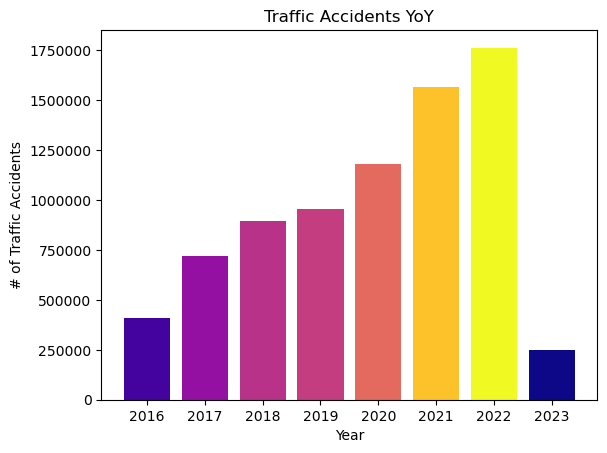

In [48]:
#What were the changes in traffic accidents over time? 
#Author: Velvet Robinson
x_axis = organized_traffic_gp.index
y_axis = organized_traffic_gp.tolist()


my_cmap = plt.get_cmap("plasma")
rescale = lambda y_axis: (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))
plt.bar(x_axis,y_axis, color=my_cmap(rescale(y_axis)))
plt.ticklabel_format(style='plain')
# plt.bar(x_axis, y_axis,color=['b','b','b','b','b','b','r','b'],alpha=0.5, align="center")
plt.title("Traffic Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/AccidentsYoY.png")
plt.show()

In [49]:
comparison_df = organized_traffic_d[["State"]]
comparison_df
changes = []
pct_changes = []
previous_row = 0

for index, x in comparison_df.iterrows():
    accidents = x["State"]
    change = (accidents-previous_row)
    pct = change/previous_row*100
    changes.append(change)
    pct_changes.append(pct)
    previous_row = accidents

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/1050712285.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  pct = change/previous_row*100


In [50]:
comparison_df.loc[:,"Yearly Change"] = changes
comparison_df.loc[:,"Percent Change"] = pct_changes

In [51]:
comparison_df.loc[:,"Percent Change"]=comparison_df["Percent Change"].map("{:,.2f}%".format)
comparison_df

,State,Yearly Change,Percent Change
Start_Year,,,
2016,410821,410821,inf%
2017,718093,307272,74.79%
2018,893426,175333,24.42%
2019,954303,60877,6.81%
2020,1178913,224610,23.54%
2021,1563753,384840,32.64%
2022,1762452,198699,12.71%
2023,246633,-1515819,-86.01%


In [52]:
#Bar Graph, year over year of traffic accidents for all cities with pop over 100k in the US between 2016-2022
#Author: Velvet Robinson
major_cities_16_22_s = (census_traffic_df["Start_Year"] <2023) & (census_traffic_df["Population"] >=100000)
major_cities_16_22_df = census_traffic_df[major_cities_16_22_s]
major_cities_16_22_gp = major_cities_16_22_df.groupby("Start_Year").count()

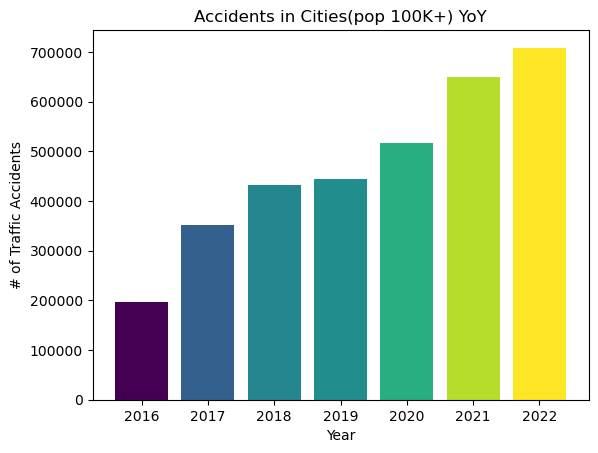

In [53]:
x_axis=major_cities_16_22_gp.index.tolist()
y_axis = major_cities_16_22_gp["State"].tolist()

my_cmap = plt.get_cmap("viridis")
rescale = lambda y_axis: (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))
plt.bar(x_axis,y_axis, color=my_cmap(rescale(y_axis)))

plt.ticklabel_format(style='plain')
# plt.bar(x_axis, y_axis,color=['g','g','g','g','g','g','r'],alpha=0.4, align="center")
plt.title("Accidents in Cities(pop 100K+) YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/MajorCitiesYoY.png")
plt.show()

In [54]:
#creating DataFrame with total accidents 2016-2022
census_traffic_16_22_s = (census_traffic_df["Start_Year"] <2023)
census_traffic_16_22_df = census_traffic_df[census_traffic_16_22_s]
census_traffic_16_22_gp = census_traffic_16_22_df.groupby("Start_Year").count()

In [55]:
#creating DataFrame with total accidents 2016-2022 and major cities(pop 100K+) 2016-2022
census_traffic_16_22_og = census_traffic_16_22_gp[["State"]]
census_traffic_16_22_rn = census_traffic_16_22_og.rename(columns={"State":"All_Accidents"})

major_cities_16_22_og = major_cities_16_22_gp[["State"]]
major_cities_16_22_rn = major_cities_16_22_og.rename(columns={"State":"Major_City_Accidents"})

census_traffic_16_22_rn["Major_City_Accidents"] = major_cities_16_22_rn["Major_City_Accidents"]

In [56]:
#Calculating percent of accidents occuring in cities w/ pop >100K
major_city_percent = (census_traffic_16_22_rn["Major_City_Accidents"]/
                      census_traffic_16_22_rn["All_Accidents"]) * 100
census_traffic_16_22_rn["Major_City_pct"] = major_city_percent.map("{:,.2f}%".format)
census_traffic_16_22_rn

,All_Accidents,Major_City_Accidents,Major_City_pct
Start_Year,,,
2016,304003,195686,64.37%
2017,526369,351006,66.68%
2018,658083,431321,65.54%
2019,714030,444736,62.29%
2020,851933,517558,60.75%
2021,1105547,650242,58.82%
2022,1210787,708272,58.50%


In [57]:
#What time of day were accidents most likely to happen? 
#Author: Velvet Robinson
day_v_night = organized_traffic_df.groupby(["Start_Year","Sunrise_Sunset"]).count().reset_index()

day_series = day_v_night["Sunrise_Sunset"] == "Day"
night_series = day_v_night["Sunrise_Sunset"] == "Night"

In [58]:
day_df = day_v_night.loc[day_series]
day_count= day_df[["Start_Year","State"]]
day_count_r = day_count.rename(columns={"State":"Day_Count"})

night_df = day_v_night.loc[night_series]
night_count= night_df[["Start_Year","State"]]
night_count_r = night_count.rename(columns={"State":"Night_Count"})

day_night_df = pd.merge(night_count_r,day_count_r,on="Start_Year")

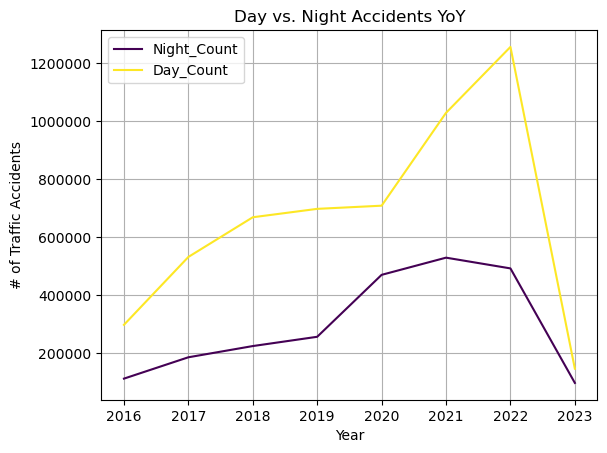

In [59]:
day_night_df.plot(x="Start_Year",kind="line",grid=True,colormap='viridis')
plt.ticklabel_format(style='plain')

plt.title("Day vs. Night Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/NigthtvDay.png")
plt.show()

In [60]:
#Adding total accidents to DF
total_accident = day_night_df[["Night_Count","Day_Count"]].sum(axis=1)
day_night_df["Total_Count"] = total_accident

In [61]:
#adding percentage of night v. day accidents
day_percent = (day_night_df["Day_Count"]/day_night_df["Total_Count"]) * 100
night_percent = (day_night_df["Night_Count"]/day_night_df["Total_Count"]) * 100

day_night_df["Night_Pct"] = night_percent.map("{:,.2f}%".format)
day_night_df["Day_Pct"] = day_percent.map("{:,.2f}%".format)


day_night_df

,Start_Year,Night_Count,Day_Count,Total_Count,Night_Pct,Day_Pct
0,2016,112742,298048,410790,27.45%,72.55%
1,2017,186263,531794,718057,25.94%,74.06%
2,2018,224905,668504,893409,25.17%,74.83%
3,2019,256833,697447,954280,26.91%,73.09%
4,2020,470174,708362,1178536,39.89%,60.11%
5,2021,529367,1028195,1557562,33.99%,66.01%
6,2022,492367,1255189,1747556,28.17%,71.83%
7,2023,97944,147014,244958,39.98%,60.02%


In [62]:
#What time of day do accidents happen for daytime accidents? 
#Bar graph for when accidents happened by hour for city with max number of accidents in 2022
#Author: Velvet Robinson
def time(raw):
    #time_string = raw[11:]
    time = dt.datetime.fromisoformat(raw).time()
    time_string = time.isoformat()
    return time_string

In [63]:
organized_traffic_df.loc[:, "Start_Timestamp"] = organized_traffic_df['Start_Time'].map(time)

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/1431660003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organized_traffic_df.loc[:, "Start_Timestamp"] = organized_traffic_df['Start_Time'].map(time)


In [64]:
tod= "Day"
tod_time_accidents = organized_traffic_df[organized_traffic_df["Sunrise_Sunset"]== tod]
tod_time_accidents_og = tod_time_accidents[["Start_Year","Start_Time","End_Time","Start_Timestamp","Sunrise_Sunset","State"]]
tod_time_accidents_og

,Start_Year,Start_Time,End_Time,Start_Timestamp,Sunrise_Sunset,State
4,2016,2016-02-08 07:39:07,2016-02-08 08:09:07,07:39:07,Day,OH
5,2016,2016-02-08 07:44:26,2016-02-08 08:14:26,07:44:26,Day,OH
6,2016,2016-02-08 07:59:35,2016-02-08 08:29:35,07:59:35,Day,OH
7,2016,2016-02-08 07:59:58,2016-02-08 08:29:58,07:59:58,Day,OH
8,2016,2016-02-08 08:00:40,2016-02-08 08:30:40,08:00:40,Day,OH
...,...,...,...,...,...,...
7728389,2019,2019-08-23 18:03:25,2019-08-23 18:32:01,18:03:25,Day,CA
7728390,2019,2019-08-23 19:11:30,2019-08-23 19:38:23,19:11:30,Day,CA
7728391,2019,2019-08-23 19:00:21,2019-08-23 19:28:49,19:00:21,Day,CA
7728392,2019,2019-08-23 19:00:21,2019-08-23 19:29:42,19:00:21,Day,CA


In [65]:
Year = 2022
single_yr_df = tod_time_accidents_og[tod_time_accidents_og["Start_Year"]==Year]

In [66]:
single_yr_df.loc[:,"Hour"] = pd.to_datetime(single_yr_df["Start_Timestamp"],format='%H:%M:%S').dt.hour

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/719576505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_yr_df.loc[:,"Hour"] = pd.to_datetime(single_yr_df["Start_Timestamp"],format='%H:%M:%S').dt.hour


In [67]:
# Establish the bins 
morning_bins = [3,12,18,21]
labels = ["Morning 4am-12pm","Afternoon 1pm-6pm","Evening 7pm-9pm"]

In [68]:
single_yr_df.loc[:,"Time of Day Ranges"] = pd.cut(single_yr_df["Hour"],morning_bins,labels=labels)

/var/folders/g7/8_nfr5nn6_d576ng21c0x7x40000gn/T/ipykernel_29777/4203710015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_yr_df.loc[:,"Time of Day Ranges"] = pd.cut(single_yr_df["Hour"],morning_bins,labels=labels)


In [69]:
single_yr_gp = single_yr_df.groupby("Time of Day Ranges").count()
single_yr_og = single_yr_gp[["State"]]
single_yr_rn = single_yr_og.rename(columns={"State":"Count"})

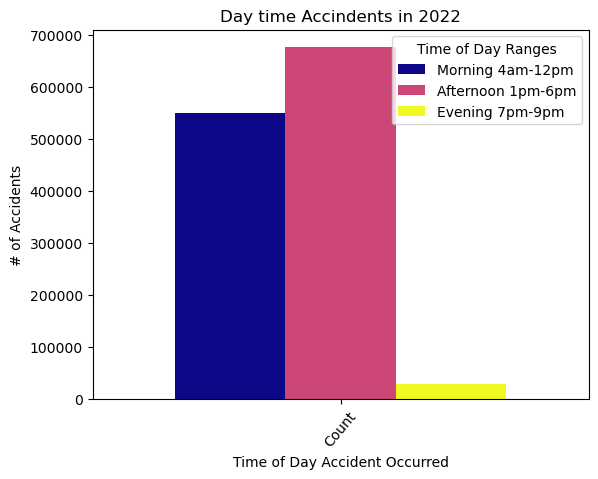

In [70]:
single_yr_rn.transpose().plot(kind="bar",width=1, xlabel="Time of Day Accident Occurred",
                              title=f"{tod} time Accindents in {Year}", ylabel="# of Accidents",
                              rot=50, colormap='plasma'
                              )

plt.savefig("outputs/2022DaytimeAccidents.png")
plt.show()

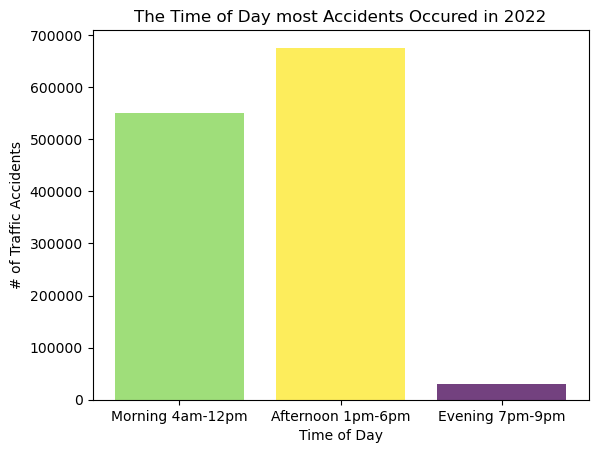

In [71]:
x = single_yr_rn.index.to_list()
y = single_yr_rn["Count"].to_list()

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.bar(x, y, color=my_cmap(rescale(y)), alpha=0.75)

plt.title(f"The Time of Day most Accidents Occured in 2022")
plt.xlabel(f"Time of Day")
plt.ylabel(f"# of Traffic Accidents")

plt.savefig("outputs/2022DaytimeAccidentsv2.png")
plt.show()